#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 05
**CH05A What Likelihood of Loss to Expect on a Stock Portfolio?**

using the sp500 dataset

version 1.0 2021-05-05

In [1]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
from mizani.formatters import percent_format
from plotnine import *
from datetime import datetime
from scipy.stats import norm

warnings.filterwarnings("ignore")


In [2]:
# Current script folder
current_path = os.getcwd()
dirname = current_path.split("da_case_studies")[0]

# location folders
data_in = dirname + "da_data_repo/sp500/clean/"
data_out = dirname + "da_case_studies/ch05-stock-market-loss-generalize/"
output = dirname + "da_case_studies/ch05-stock-market-loss-generalize/output/"
func = dirname + "da_case_studies/ch00-tech-prep/"
sys.path.append(func)


In [3]:
# Import the prewritten helper functions
from py_helper_functions import *


In [4]:
sp500 = (
    pd.read_csv(data_in + "SP500_2006_16_data.csv")
    .replace("", np.nan)
    .replace("#N/A", np.nan)
)
sp500 = sp500.dropna().reset_index(drop=True)


In [5]:
# CREATE PERCENT RETURN
sp500["pct_return"] = (
    (sp500["VALUE"] - sp500.set_index("DATE").shift(1).reset_index(drop=True)["VALUE"])
    / sp500.set_index("DATE").shift(1).reset_index(drop=True)["VALUE"]
    * 100
)


In [6]:
sp500["DATE"] = pd.to_datetime(sp500["DATE"], format="%Y-%m-%d")
sp500["year"] = sp500["DATE"].apply(lambda x: x.year)
sp500["month"] = sp500["DATE"].apply(lambda x: x.month)
sp500["yearmonth"] = sp500["year"] * 100 + sp500["month"]


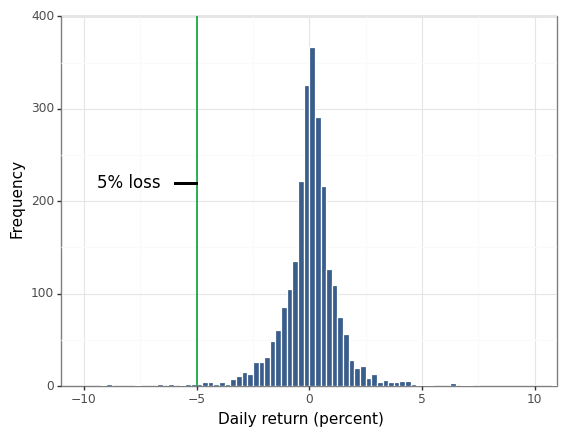

<ggplot: (402451219)>

In [7]:
(
    ggplot(sp500, aes("pct_return"))
    + geom_histogram(
        binwidth=0.25, color="white", fill=color[0], boundary=0, closed="left"
    )
    + geom_vline(xintercept=-5, size=0.7, color=color[1])
    + labs(x="Daily return (percent)", y="Frequency")
    + coord_cartesian(xlim=[-10, 10], ylim=[0, 400])
    + scale_y_continuous(expand=[0, 0])
    + geom_segment(aes(x=-6, y=220, xend=-5, yend=220))
    + annotate("text", x=-8, y=220, label="5% loss", size=12)
    + theme_bw()
)


In [8]:
pct_return = sp500.pct_return.dropna()


In [9]:
def create_samples(vector, n_samples, n_obs):
    samples_pcloss = [None] * (n_samples + 1)
    for i in range(1, n_samples + 1):
        single_sample = np.random.choice(vector, size=n_obs, replace=False)
        samples_pcloss[i] = sum(single_sample < -5) / n_obs * 100
    return samples_pcloss


In [10]:
np.random.seed = 123
nobs_1000 = create_samples(pct_return, 10000, 1000)
nobs_500 = create_samples(pct_return, 10000, 500)


In [11]:
nobs_df = pd.DataFrame({"nobs_500": nobs_500, "nobs_1000": nobs_1000}).drop(0)


In [12]:
nobs_df


,nobs_500,nobs_1000
1,0.4,0.5
2,1.0,0.6
3,0.4,0.7
4,0.6,0.5
5,0.6,0.4
...,...,...
9996,0.8,0.3
9997,0.6,0.7
9998,0.6,0.5
9999,0.6,0.4


In [13]:
error = (
    norm.ppf(0.975) * np.std(nobs_df["nobs_1000"]) / np.sqrt(len(nobs_df["nobs_1000"]))
)
left = np.mean(nobs_df["nobs_1000"]) - error
right = np.mean(nobs_df["nobs_1000"]) + error


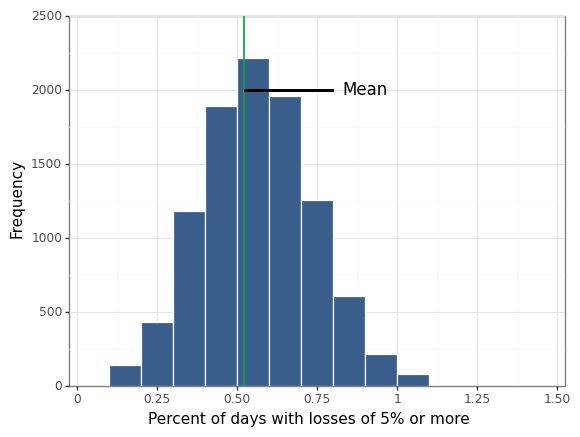

<ggplot: (675995453)>

In [14]:
# Figure 5.2
(
    ggplot(nobs_df, aes(nobs_1000[1:]))
    + geom_histogram(
        binwidth=0.1,
        color="white",
        fill=color[0],
        alpha=0.8,
        center=0.75,
        closed="left",
    )
    + labs(x="Percent of days with losses of 5% or more", y="Frequency")
    + geom_vline(
        aes(xintercept=np.mean(pd.Series(nobs_500).dropna())), color=color[1], size=0.7
    )
    + coord_cartesian(xlim=[0, 1.5], ylim=(0, 2500))
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 1.5), breaks=seq(0, 1.6, 0.25))
    + scale_y_continuous(
        expand=(0.00, 0.00), limits=(0, 2500), breaks=seq(0, 2501, 500)
    )
    + geom_segment(aes(x=0.8, y=2000, xend=0.52, yend=2000))
    + annotate("text", x=0.9, y=2000, label="Mean", size=12)
    + theme_bw()
)


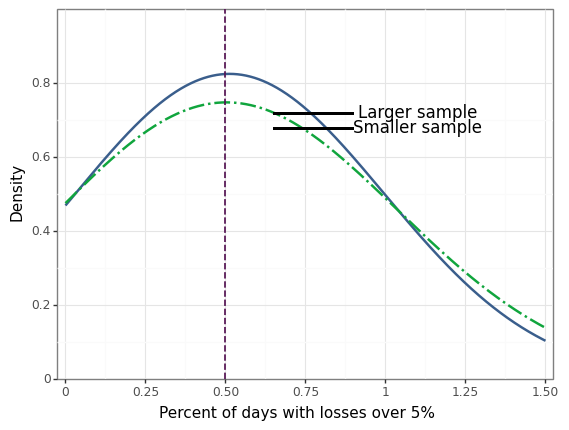

<ggplot: (676501312)>

In [15]:
# Figure 5.3 - NOt working with epanechnikov kernel
(
    ggplot(nobs_df)
    + stat_density(aes(x="nobs_1000"), color=color[0], geom="line", bw=0.45, size=1)
    + stat_density(
        aes("nobs_500"),
        color=color[1],
        geom="line",
        bw=0.45,
        linetype="dashdot",
        size=1,
    )
    + labs(x="Percent of days with losses over 5%", y="Density")
    + geom_vline(xintercept=0.5, color=color[2], size=0.7, linetype="dashed")
    + geom_segment(
        aes(x=0.9, y=0.72, xend=0.65, yend=0.72),
        size=0.5,
    )
    + annotate("text", x=1.1, y=0.72, label="Larger sample", size=12)
    + geom_segment(aes(x=0.9, y=0.68, xend=0.65, yend=0.68), size=0.5)
    + annotate("text", x=1.1, y=0.68, label="Smaller sample", size=12)
    + scale_x_continuous(
        expand=(0.01, 0.01), limits=(0, 1.5), breaks=seq(0, 1.51, 0.25)
    )
    + scale_y_continuous(expand=(0.00, 0.00), limits=(0, 1), breaks=seq(0, 0.81, 0.2))
    + theme_bw()
    + theme(
        legend_position="none",
    )
)


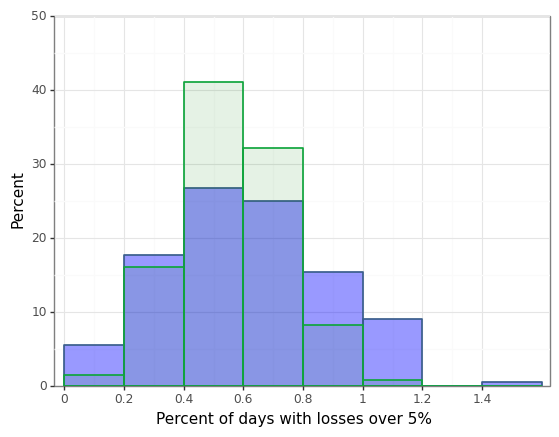

<ggplot: (676510772)>

In [16]:
(
    ggplot(nobs_df)
    + geom_histogram(
        aes(x="nobs_500", y="stat(count)/sum(stat(count))*100"),
        color=color[0],
        fill="blue",
        binwidth=0.2,
        center=0.5,
        size=0.7,
        alpha=0.4,
        closed="left",
    )
    + geom_histogram(
        aes(x="nobs_1000", y="stat(count)/sum(stat(count))*100"),
        color=color[1],
        fill="green",
        binwidth=0.2,
        center=0.5,
        alpha=0.1,
        size=0.7,
        closed="left",
    )
    + ylab("Percent")
    + xlab("Percent of days with losses over 5%")
    + scale_x_continuous(
        expand=(0.01, 0.01), limits=(-0.01, 1.6), breaks=seq(0, 1.6, 0.2)
    )
    + scale_y_continuous(expand=(0.00, 0.00), limits=(0, 50))
    + scale_color_manual(
        labels=("N = 1000", "N = 500"), name="", values=(color[1], color[0])
    )
    + scale_alpha_identity()
    + scale_fill_identity()
    + theme_bw()
    + theme(
        legend_direction="horizontal",
    )
)


In [17]:
####################################
# BOOTSRTAP SAMPLES
np.random.seed = 573164
M = 10000
Results = np.zeros((M, 10))


In [18]:
for i in range(1, M + 1):
    bsample = np.random.choice(sp500["pct_return"], size=sp500.shape[0], replace=True)
    for j in range(1, 11):
        loss = pd.Series(bsample < (-j)).apply(lambda x: float(x)) * 100
        Results[i - 1, j - 1] = np.mean(loss)


In [19]:
Results = pd.DataFrame(
    Results,
    columns=[
        "loss1",
        "loss2",
        "loss3",
        "loss4",
        "loss5",
        "loss6",
        "loss7",
        "loss8",
        "loss9",
        "loss10",
    ],
)


In [20]:
Results


,loss1,loss2,loss3,loss4,loss5,loss6,loss7,loss8,loss9,loss10
0,13.457721,5.160778,2.421596,1.151250,0.674871,0.516078,0.317586,0.317586,0.039698,0.0
1,15.998412,6.272330,2.381898,1.349742,0.674871,0.476380,0.238190,0.119095,0.039698,0.0
2,13.854704,4.803493,2.024613,0.873362,0.317586,0.198491,0.198491,0.079397,0.079397,0.0
3,13.934101,5.637158,2.104010,1.270345,0.754268,0.396983,0.158793,0.158793,0.039698,0.0
4,15.442636,5.478364,2.540691,1.429139,0.873362,0.516078,0.357285,0.277888,0.119095,0.0
...,...,...,...,...,...,...,...,...,...,...
9995,14.767765,4.922588,1.945216,0.873362,0.516078,0.238190,0.158793,0.079397,0.079397,0.0
9996,13.100437,5.319571,1.984915,0.913061,0.635173,0.476380,0.198491,0.119095,0.039698,0.0
9997,13.735609,4.922588,1.945216,0.793966,0.516078,0.357285,0.277888,0.198491,0.000000,0.0
9998,15.204446,5.121080,2.342199,1.151250,0.833664,0.436681,0.238190,0.198491,0.079397,0.0


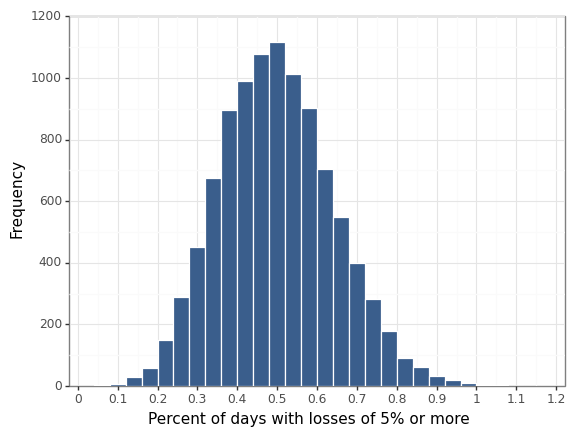

<ggplot: (676502029)>

In [21]:
(
    ggplot(Results, aes("loss5"))
    + geom_histogram(
        fill=color[0], color="white", binwidth=0.04, boundary=0, closed="left"
    )
    + scale_y_continuous(expand=(0, 0), limits=(0, 1200), breaks=seq(0, 1201, 200))
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 1.2), breaks=seq(0, 1.21, 0.1))
    + labs(x="Percent of days with losses of 5% or more", y="Frequency")
    + theme_bw()
)
